# Here we run some of the previous tests but with nested subspaces, and try the cross-validation method to find an optimal rank $n$ for $V_n$
Starting with the usual ground-truth $u_h$!

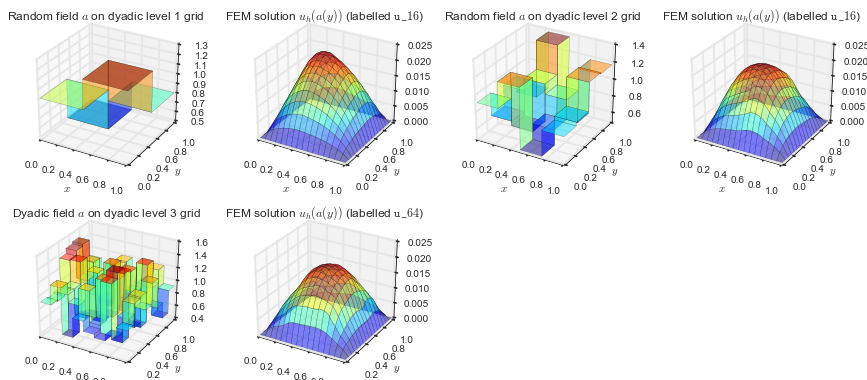

In [1]:
import numpy as np
import importlib
import dyadic_fem as df
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
importlib.reload(df)
%matplotlib inline

fem_div = 7

a_4 = df.make_dyadic_random_field(div=1, a_bar=1.0, c=0.5, seed=1)
fem_4 = df.DyadicFEMSolver(div=fem_div, rand_field=a_4, f=1.0)
fem_4.solve()

a_16 = df.make_dyadic_random_field(div=2, a_bar=1.0, c=0.5, seed=1)
fem_16 = df.DyadicFEMSolver(div=fem_div, rand_field=a_16, f=1.0)
fem_16.solve()

a_64 = df.make_dyadic_random_field(div=3, a_bar=1.0, c=0.5, seed=1)
fem_64 = df.DyadicFEMSolver(div=fem_div, rand_field=a_64, f=1.0)
fem_64.solve()

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(3, 4, 1, projection='3d')
a_4.plot(ax, title='Random field $a$ on dyadic level 1 grid')
ax = fig.add_subplot(3, 4, 2, projection='3d')
fem_4.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_16}$)')
ax = fig.add_subplot(3, 4, 3, projection='3d')
a_16.plot(ax, title='Random field $a$ on dyadic level 2 grid')
ax = fig.add_subplot(3, 4, 4, projection='3d')
fem_16.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_16}$)')
ax = fig.add_subplot(3, 4, 5, projection='3d')
a_64.plot(ax, title='Dyadic field $a$ on dyadic level 3 grid')
ax = fig.add_subplot(3, 4, 6, projection='3d')
fem_64.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_64}$)')
plt.show()

## We test the nested spaces, which here is simply done by first creating ambient spaces $W_{\mathrm{big}}$ and $V_{\mathrm{big}}$ from which we pluck subspaces $W_m$ and $V_n$. 
In this case they are both of rank 150. Also in this case $V_n$ is generated from the 64-dimensional chess-board random fields, i.e. dyadic-level 3, as we are going to be looking at the solution ```fem_64.u```

In [2]:
# local_width is the width of the measurement squares
local_width = 2**(fem_div - 4)

ms = (25, 50, 100, 150)
m_big = ms[-1] # = 150

# We make the ambient spaces for Wm and Vn
Wbig = df.make_random_local_integration_basis(m=m_big, div=fem_div, width=local_width, space='H1')
Wbig = Wbig.orthonormalise()
Vbig, V_fields = df.make_reduced_basis(n=m_big, field_div=3, fem_div=fem_div, space='H1')
Vbig = Vbig.orthonormalise()

### Now we demonstrate that our nested spaces work 
....and that we get the expected monotonic decrease, for example, in $\| u - P_{V_n} u \|_{H_0^1}$

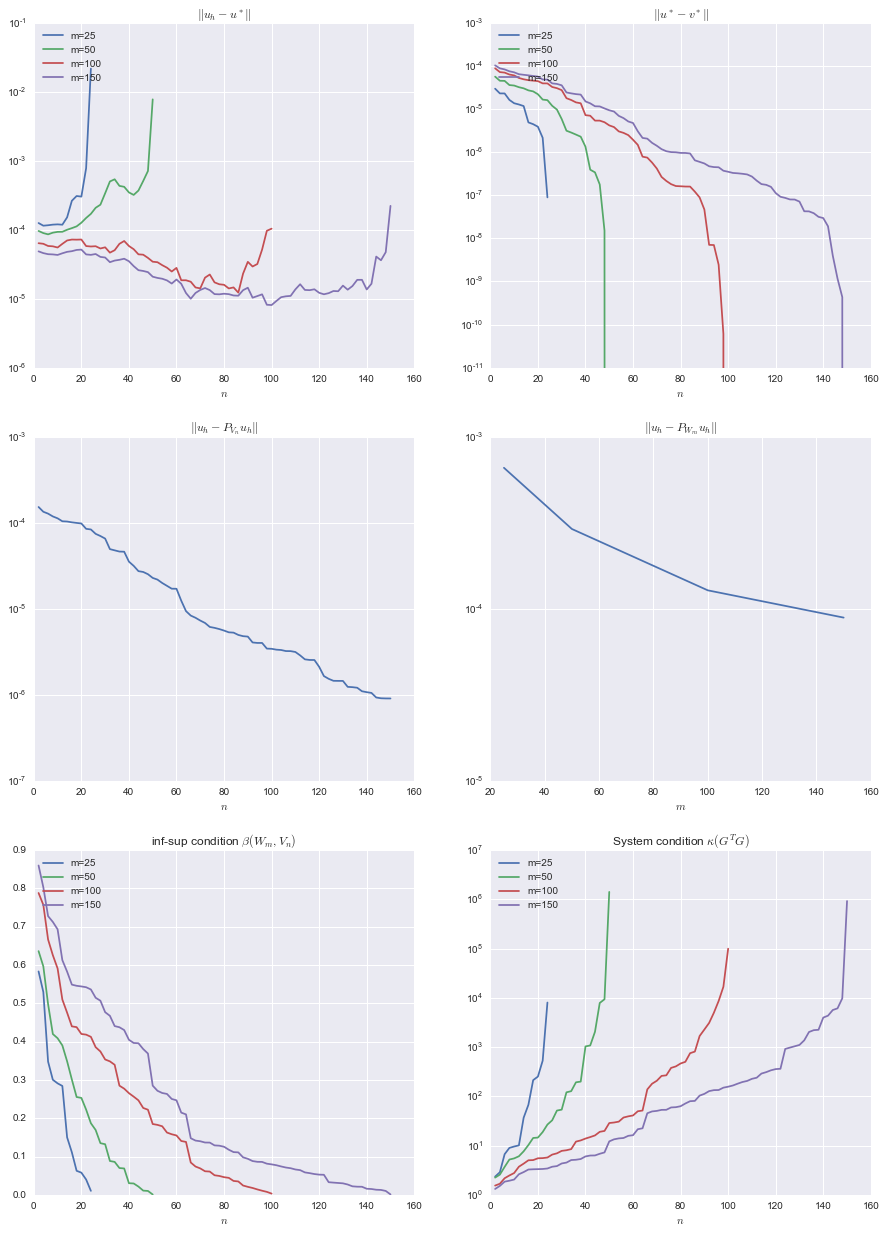

In [7]:
axs = []
fig = plt.figure(figsize=(15, 21))
axs.append(fig.add_subplot(3, 2, 1, title='$\| u_h - u^* \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 2, title='$\| u^* - v^* \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 3, title='$\| u_h - P_{V_n} u_h \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 4, title='$\| u_h - P_{W_m} u_h \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$m$')
axs.append(fig.add_subplot(3, 2, 5, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 6, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')

m_stats = np.zeros([2, len(ms)])

for j, m in enumerate(ms):
    
    # If *not* nested use this code here:
    #Wm = df.make_random_local_integration_basis(m=m, div=fem_div, width=local_width, space='H1')
    #Wm = Wm.orthonormalise()
    
    Wm = Wbig.subspace(slice(0,m))
    
    # This is the measurement vector
    w = Wm.dot(fem_64.u)
    u_p_w = Wm.project(fem_64.u)

    m_stats[0, j] = (fem_64.u-u_p_w).norm(space='H1')
    
    ns = range(2, m+1, 2)
    stats = np.zeros([5, len(ns)])
    for i, n in enumerate(ns):
    
        Vn = Vbig.subspace(slice(0,n))
        # If *not* nested use this code here:
        #Vn, V_fields = df.make_reduced_basis(n=n, field_div=2, fem_div=fem_div, space='H1')
        #Vn = Vn.orthonormalise()
        
        u_p_v = Vn.project(fem_64.u)
        
        BP = df.BasisPair(Wm, Vn)
        FB = BP.make_favorable_basis()
        
        u_star, v_star, w_p, v_w_p = FB.measure_and_reconstruct(fem_64.u)
        
        stats[0, i] = (fem_64.u-u_star).norm(space='H1')
        stats[1, i] = (u_star - v_star).norm(space='H1')
        stats[2, i] = FB.beta()
        stats[3, i] = np.linalg.cond(BP.G.T @ BP.G)
        stats[4, i] = (fem_64.u - u_p_v).norm(space='H1')
        
    axs[0].plot(ns, stats[0,:], label='m={0}'.format(m))
    axs[0].legend(loc=2)
    axs[1].plot(ns, stats[1,:], label='m={0}'.format(m))
    axs[1].legend(loc=2)
    axs[4].plot(ns, stats[2,:], label='m={0}'.format(m))
    axs[4].legend(loc=2)
    axs[5].plot(ns, stats[3,:], label='m={0}'.format(m))
    axs[5].legend(loc=2)

axs[2].plot(ns, stats[4,:], label='m={0}'.format(m))
axs[3].plot(ms, m_stats[0,:], label='m={0}'.format(m))
    
plt.show()